In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')
%load_ext autoreload
%autoreload 2

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
from financial_common.indicator.indicator import Indicator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.mstats import winsorize

In [3]:
## Import standard packages
from datetime import timedelta, datetime, timezone
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
rolling_window = 10
market.connect()
prices = []
skips = 1
model_end = 2021
backtest_end = 2025
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price = price[(price["date"]>=datetime(model_end-1,12,31,tzinfo=timezone.utc)-timedelta(days=rolling_window*2)) & (price["year"]<backtest_end)]
            price.sort_values("date", inplace=True)
            price["dividend"] = 0
            price["coefficient_of_variation"] = 1
            price = Metric.MARKETCAP.calculate(price,timeframe=rolling_window,live=False)
            price = Metric.STANDARD_DEV.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_OPEN.calculate(price,timeframe=rolling_window)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████████████████████| 11273/11273 [03:04<00:00, 61.05it/s]


In [8]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "volume_price"
                                                            ]
                                                            ,num_of_groups=[1]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[1]
                                                            ,min_prices=[0.1]
                                                            ,max_market_caps = [10000000]
                                                            ,min_market_caps = [1000000]
                                                            ,stoplosses=[1]
                                                            ,rolling_windows=[5]
                                                            ,leverages=[1]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "day" and "top_blacklist" in portfolio.selection_type.label \
        and portfolio.allocation_type.label == "equal" \
        and portfolio.ranking_metric != "optimal" \
        and portfolio.grouping_type.value == "standard_dev" \
        and portfolio.position_type.label == "long" and portfolio.max_price > portfolio.min_price:
        filtered_portfolios.append(portfolio)

In [9]:
from financial_common.indicator.indicator import Indicator
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        indicator_class = Indicator.indicator_type_factory(portfolio.ranking_metric)
        simulation = pd.concat(prices)
        simulation = simulation.sort_values("date")
        simulation = simulation.groupby("ticker").apply(lambda x: indicator_class.calculate(x, portfolio.rolling_window,live=False)).reset_index(drop=True).dropna()
        trades = portfolio.trades(simulation.copy())
        trades = p.additional_date_columns(trades)
        trades.sort_values("date")
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|███████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.55s/it]


In [10]:
a = pd.DataFrame(analysises)

In [11]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","max_market_cap","min_market_cap","timeframe","selection_percentage","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,stoploss,num_of_groups,max_price,min_price,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
0,volume_price,long,STANDARD_DEV,top_blacklist,equal,1,1,1,0.1,1,1.026542,1149.108763,0.999627,121.785874,0.008429,-131.475558,0.303953,-3.646015


In [12]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades).sort_values("date")
portfolio = pm.portfolio(trades,benchmark)
trades["derpclose"] = trades["adjclose"].round(1)

In [13]:
trades.groupby("derpclose")["unweighted_return"].mean().sort_values().tail(50)

derpclose
0.5    0.996620
0.7    1.002257
1.0    1.003461
0.9    1.004027
0.6    1.004587
0.3    1.009596
0.2    1.012119
0.4    1.026156
0.1    1.043016
0.8    1.114222
Name: unweighted_return, dtype: float64

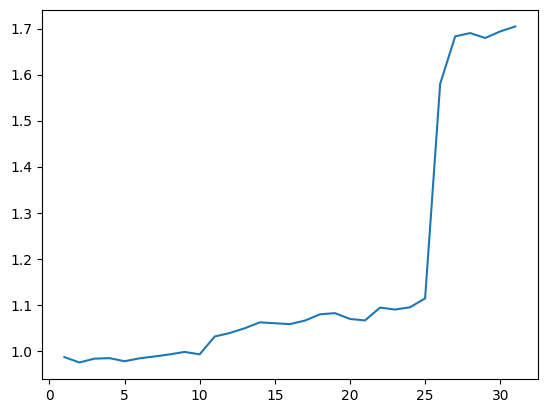

In [14]:
portfolio["weekday"] = portfolio["date"].dt.weekday
portfolio["month"] = portfolio["date"].dt.month
portfolio["week"] = [x.week for x in portfolio["date"]]
portfolio["month_day"] = portfolio["date"].dt.day

metric = "month_day"
view = portfolio.groupby(metric).mean().reset_index().sort_values(metric)
view["raw_pnl"] = view["weighted_return"].cumprod()
plt.plot(view[metric],view["raw_pnl"])
plt.show()

In [15]:
trades.head(20)

,year,day,ticker,date,weekday,market_cap,adjclose,sell_price,standard_dev,volume_price,...,position_type,weight,unweighted_return,winsorized_return,weighted_return,return,month,quarter,week,derpclose
0,2020,364,NAK,2020-12-29 00:00:00+00:00,1,3.185253e+06,0.3212,0.3237,0.009102,8.958982,...,1.0,1.0,1.007783,1.007783,0.007783,0.000057,12,4,53,0.3
1,2020,365,SENS,2020-12-30 00:00:00+00:00,2,7.508041e+06,0.8895,0.8950,0.228542,7.353639,...,1.0,1.0,1.006183,1.006183,0.006183,0.000046,12,4,53,0.9
2,2020,366,CIG,2020-12-31 00:00:00+00:00,3,9.069462e+06,0.8074,0.8130,0.016971,10.955869,...,1.0,1.0,1.006936,1.006936,0.006936,0.000051,12,4,53,0.8
203,2021,4,NAK,2021-01-04 00:00:00+00:00,0,3.363615e+06,0.3520,0.3850,0.006592,9.978858,...,1.0,1.0,1.093750,1.060559,0.093750,0.000446,1,1,1,0.4
210,2021,5,CIG,2021-01-05 00:00:00+00:00,1,8.512123e+06,0.7920,0.7612,0.016933,10.220752,...,1.0,1.0,0.961111,0.961111,-0.038889,-0.000286,1,1,1,0.8
219,2021,6,CIG,2021-01-06 00:00:00+00:00,2,9.739268e+06,0.8116,0.8036,0.016898,11.643387,...,1.0,1.0,0.990143,0.990143,-0.009857,-0.000073,1,1,1,0.8
227,2021,7,SENS,2021-01-07 00:00:00+00:00,3,8.594840e+06,0.8799,0.8988,0.166152,8.290542,...,1.0,1.0,1.021480,1.021480,0.021480,0.000158,1,1,1,0.9
235,2021,8,NAK,2021-01-08 00:00:00+00:00,4,6.356397e+06,0.3698,0.3990,0.030961,15.494538,...,1.0,1.0,1.078962,1.060559,0.078962,0.000446,1,1,1,0.4
16,2021,11,NAK,2021-01-11 00:00:00+00:00,0,4.470912e+06,0.4377,0.4172,0.031250,11.504867,...,1.0,1.0,0.953164,0.953164,-0.046836,-0.000345,1,1,2,0.4
23,2021,12,ELP,2021-01-12 00:00:00+00:00,1,7.582117e+06,0.8005,0.7948,0.033208,8.846624,...,1.0,1.0,0.992879,0.992879,-0.007121,-0.000052,1,1,2,0.8


In [16]:
orivault.connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()